In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import DataFrame 
import nltk

from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from scipy.spatial.distance import cosine
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

import re
import string
from sklearn.metrics import mean_squared_error

In [3]:
column_names = ['user_id', 'product_id', 'rating', 'timestamp']

In [4]:
df = pd.read_csv('ratings_Electronics.csv', names=column_names)

In [5]:
print(df.columns)
print(df.shape)

Index(['user_id', 'product_id', 'rating', 'timestamp'], dtype='object')
(7824482, 4)


In [7]:
dfCount = df.head(100)

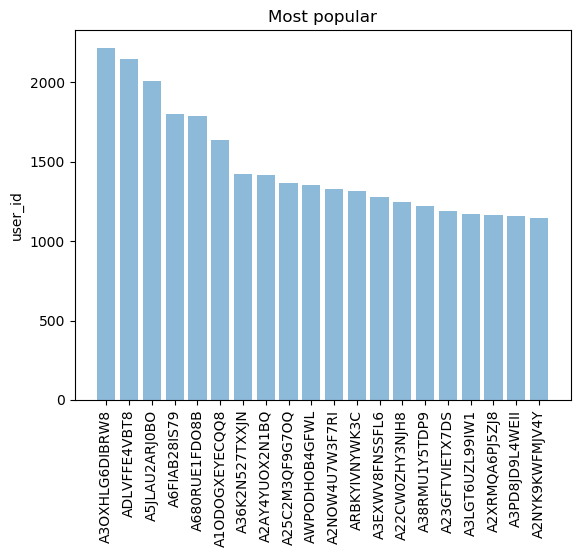

In [8]:
popular = df[['user_id','rating']].groupby('user_id').sum().reset_index()
popular_20 = popular.sort_values('rating', ascending=False).head(n=20)
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
 
objects = (list(popular_20['user_id']))
y_pos = np.arange(len(objects))
performance = list(popular_20['rating'])
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects, rotation='vertical')
plt.ylabel('user_id')
plt.title('Most popular')
 
plt.show()

In [7]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(dfCount, test_size = 0.20, random_state=0)
print(train_data.head(5))

                user_id     item_id  rating  totalReviewers
1569982  A218FLZ62LJJJ5  B00119T6NQ     5.0      1238025600
599094   A3P7C1BYT1E70E  B0007MXZB2     1.0      1257379200
83866     APQY23KSBBCNO  B000053HH5     5.0      1259452800
5420345  A38H5ZVPLI6V5R  B006K553LU     5.0      1354752000
862059   A109F6FNGOJ7BD  B000EMU4HS     5.0      1173398400


In [8]:
#Class for Popularity based Recommender System model
class popularity_recommender_py():
    def __init__(dfCount):
        dfCount.train_data = None
        dfCount.user_id = None
        dfCount.item_id = None
        dfCount.popularity_recommendations = None

In [9]:
#Create the popularity based recommender system model
def create(dfCount, train_data, user_id, item_id):
        dfCount.train_data = train_data
        dfCount.user_id = user_id
        dfCount.item_id = item_id

In [10]:
train_data, test_data = train_test_split(dfCount, test_size = 0.30, random_state=0)

In [12]:
def create_popularity_recommendation(train_data, user_id, item_id):
    #Get a count of user_ids for each unique song as recommendation score
    train_data_grouped = train_data.groupby([item_id]).agg({user_id: 'count'}).reset_index()
    train_data_grouped.rename(columns = {user_id: 'score'},inplace=True)
    
    #Sort the songs based upon recommendation score
    train_data_sort = train_data_grouped.sort_values(['score', item_id], ascending = [0,1])
    
    #Generate a recommendation rank based upon score
    train_data_sort['Rank'] = train_data_sort['score'].rank(ascending=0, method='first')
        
    #Get the top 10 recommendations
    popularity_recommendations = train_data_sort.head(20)
    return popularity_recommendations

In [13]:
recomendations = create_popularity_recommendation(dfCount,'user_id','rating')

In [14]:
recomendations

,rating,score,Rank
4,5.0,4347541,1.0
3,4.0,1485781,2.0
0,1.0,901765,3.0
2,3.0,633073,4.0
1,2.0,456322,5.0


In [15]:
def distance_similarity_score(user1,user2):
    '''
    user1 & user2 : user ids of two users between which similarity score is to be calculated.
    '''
    both_watch_count = 0
    for element in dfCount.loc[dfCount.user_id==user1,'item_id'].tolist():
        if element in dfCount.loc[dfCount.user_id==user2,'item_id'].tolist():
            both_watch_count += 1
    if both_watch_count == 0 :
        return 0
    distance = []
    for element in dfCount.loc[dfCount.user_id==user1,'item_id'].tolist():
        if element in dfCount.loc[dfCount.user_id==user2,'item_id'].tolist():
            rating1 = get_rating_(user1,element)
            rating2 = get_rating_(user2,element)
            distance.append(pow(rating1 - rating2, 2))
    total_distance = sum(distance)
    return 1/(1+sqrt(total_distance))

In [16]:
distance_similarity_score(1,50)

0

In [17]:
def pearson_correlation_score(user1,user2):
    '''
    user1 & user2 : user ids of two users between which similarity score is to be calculated.
    '''
    both_watch_count = []
    for element in dfCount.loc[dfCount.user_id==user1,'item_id'].tolist():
        if element in dfCount.loc[dfCount.user_id==user2,'item_id'].tolist():
            both_watch_count.append(element)
    if len(both_watch_count) == 0 :
        return 0
    rating_sum_1 = sum([get_rating_(user1,element) for element in both_watch_count])
    rating_sum_2 = sum([get_rating_(user2,element) for element in both_watch_count])
    rating_squared_sum_1 = sum([pow(get_rating_(user1,element),2) for element in both_watch_count])
    rating_squared_sum_2 = sum([pow(get_rating_(user2,element),2) for element in both_watch_count])
    product_sum_rating = sum([get_rating_(user1,element) * get_rating_(user2,element) for element in both_watch_count])
    
    numerator = product_sum_rating - ((rating_sum_1 * rating_sum_2) / len(both_watch_count))
    denominator = sqrt((rating_squared_sum_1 - pow(rating_sum_1,2) / len(both_watch_count)) * (rating_squared_sum_2 - pow(rating_sum_2,2) / len(both_watch_count)))
    if denominator == 0:
        return 0
    return numerator/denominator

In [18]:
pearson_correlation_score(1,310)

0

In [19]:
def most_similar_users_(user1,number_of_users,metric='pearson'):
    '''
    user1 : Targeted User
    number_of_users : number of most similar users you want to user1.
    metric : metric to be used to calculate inter-user similarity score. ('pearson' or else)
    '''
    # Getting distinct user ids.
    user_ids = dfCount.user_id.unique().tolist()
    
    # Getting similarity score between targeted and every other suer in the list(or subset of the list).
    if(metric == 'pearson'):
        similarity_score = [(pearson_correlation_score(user1,nth_user),nth_user) for nth_user in user_ids[:100] if nth_user != user1]
    else:
        similarity_score = [(distance_similarity_score(user1,nth_user),nth_user) for nth_user in user_ids[:100] if nth_user != user1]
    
    # Sorting in descending order.
    similarity_score.sort()
    similarity_score.reverse()
    
    # Returning the top most 'number_of_users' similar users. 
    return similarity_score[:number_of_users]

In [20]:
print(most_similar_users_(23,5))

[(0, 'AZYNQZ94U6VDB'), (0, 'AZQZ3STMCBG5H'), (0, 'AYTBGUX49LF3W'), (0, 'AYM7NJTTX3M0L'), (0, 'AWA0CM7TY98QX')]
